将原来的py代码修改为notebook中实现，方便调试和数据可视化

In [1]:
#模块导入
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as preprocessing
import numpy as np
from sklearn.ensemble import BaggingRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestRegressor


c:\python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\python27\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
#函数方法

def enum_to_int(data_train,data_test,columns=[]):
    # 枚举变量转int数值
    for i in range(0, len(columns)):
        column_name = columns[i]
        column_le = LabelEncoder().fit(data_train[column_name])
        column_label = column_le.transform(data_train[column_name])
        data_train[column_name] = column_label
        if any(data_test):
            column_label = column_le.transform(data_test[column_name])
            data_test[column_name] = column_label
    return data_train,data_test

def show_destr(data,columns=[]):
    # 连续取值的观察
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in range(0,len(columns)):
        fig.add_subplot(len(columns) * 100 + 10 + 1 + i)  # 最后一位编码从0开始，但是实际sbuplot需要从1开始
        column_name = columns[i]
        data[column_name].plot(kind='kde')
        plt.title(column_name)
    plt.show()
    plt.close()

def show_int(data,columns=[]):
    #显示离散型变量
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in xrange(0, len(columns)):
        fig.add_subplot(len(columns) * 100 + 10 + 1 + i)  # 最后一位编码从0开始，但是实际sbuplot需要从1开始
        column_name = columns[i]
        data[column_name].value_counts().plot(kind='bar')
        plt.title(column_name)
    plt.show()
    plt.close()

def columns_dummies(data_train,data_test,columns=[]):
    for i in range(0,len(columns)):
        column_name=columns[i]
        dummies_column = pd.get_dummies(data_train[column_name], prefix=column_name)
        data_train = pd.concat([data_train, dummies_column], axis=1)
        data_train.drop([column_name], axis=1, inplace=True)
        if any(data_test):
            dummies_column = pd.get_dummies(data_test[column_name], prefix=column_name)
            data_test = pd.concat([data_test, dummies_column], axis=1)
            data_test.drop([column_name], axis=1, inplace=True)
    return data_train,data_test

def set_missing_ages(data,columns=[],label='',algo=None):
    '''使用data数据columns中的维度来填充label字段有缺失的信息,算法为algo'''

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    data_tmp=data[columns+[label]]

    data_train=data_tmp.loc[data_tmp[label].notnull()]
    data_test=data_tmp.loc[data_tmp[label].isnull()]
    # print data_tmp[label].isnull()
    train_x=data_train[columns]
    train_y=data_train[label]
    test_x=data_test[columns]
    algo.fit(train_x,train_y)
    test_y=algo.predict(test_x)
    data.loc[(data[label].isnull()),label]=test_y
    return data,algo

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

        plt.legend(loc="best")

        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

In [3]:
data_train = pd.read_csv('d:\\TDDOWNLOAD\\ML\\titanic\\officialData\\train.csv')
data_test=pd.read_csv('d:\\TDDOWNLOAD\\ML\\titanic\\officialData\\test.csv')

In [4]:
# 枚举转int,Embarked特征train有空导致dummy后特征数量和test不同，暂时注销
# columns = [ 'Embarked', 'Sex']
# data_train,data_test=enum_to_int(data_train,data_test,columns)
# print 'data_train',data_train.head()

#单属性显示
# columns=['Survived','Pclass','SibSp','Parch','Embarked','Sex']
# show_int(data_train,columns)

In [5]:
# #缺失的属性处理
# #cabin缺失过多，将是否缺失作为新的属性
# data_train.loc[data_train['Cabin'].notnull(), 'Cabin' ] = "Yes"
# data_train.loc[data_train['Cabin'].isnull(), 'Cabin' ] = "No"
# data_test.loc[data_test['Cabin'].notnull(), 'Cabin' ] = "Yes"
# data_test.loc[data_test['Cabin'].isnull(), 'Cabin' ] = "No"
# #Age使用随机森林进行预测
# data_train,algo=set_missing_ages(data_train, columns=['Fare', 'Parch', 'SibSp', 'Pclass'], label='Age', algo=RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1))
# data_test_predict=algo.predict(data_test.loc[data_test['Age'].isnull()][['Fare', 'Parch', 'SibSp', 'Pclass']])
# data_test.loc[data_test['Age'].isnull(),'Age']=data_test_predict

c:\python27\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


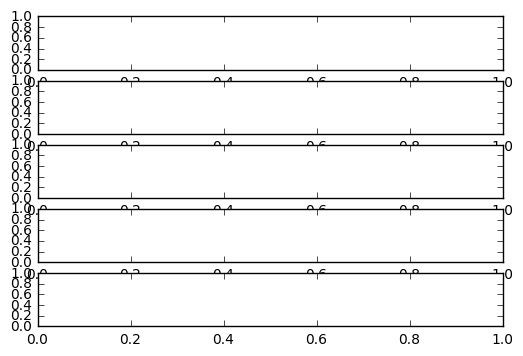

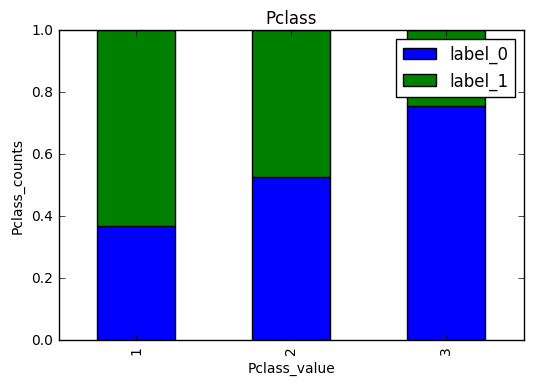

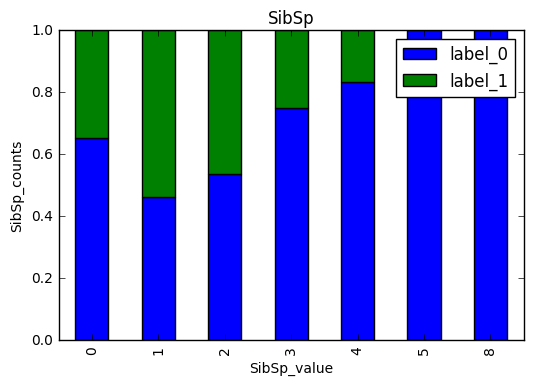

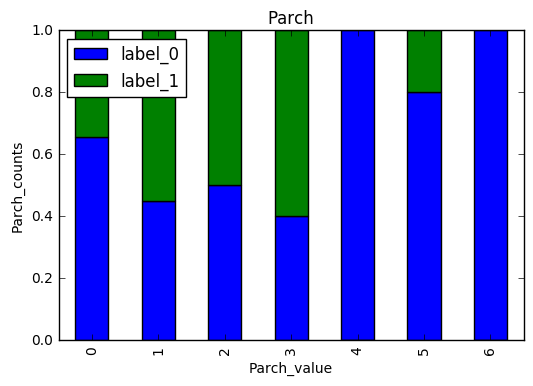

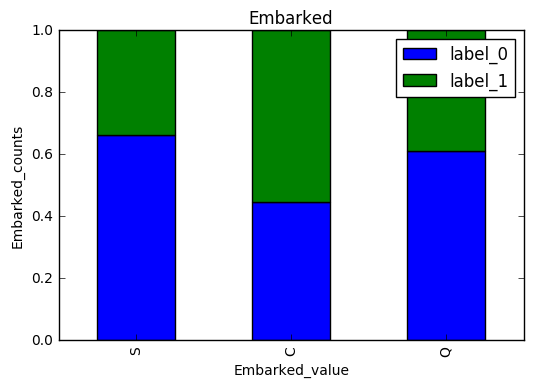

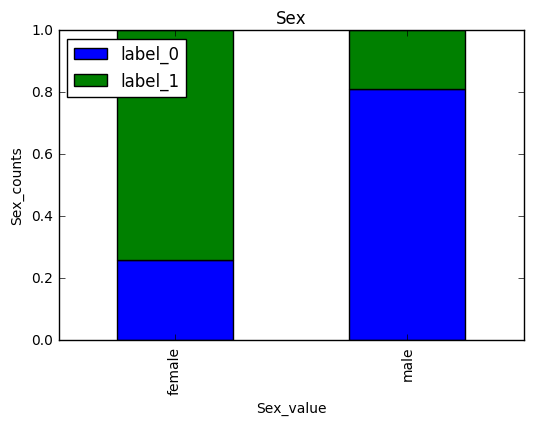

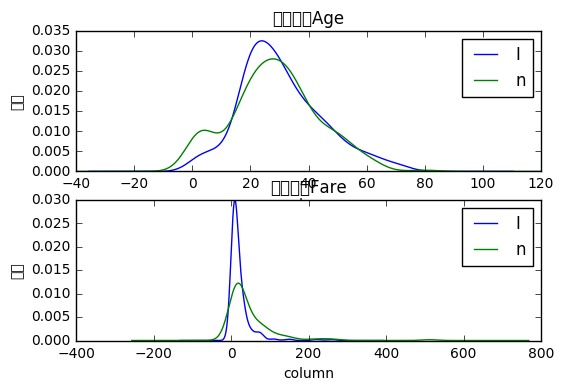

In [6]:
#mode=1时为100%模式，相关性更明显
def corr_int_label(data, columns=[], label='',mode=0):
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in range(0, len(columns)):
        column_name = columns[i]
        fig.add_subplot(len(columns) * 100 + 10 + 1 + i)
        data[label]=data[label].apply(lambda x:int(x))
        value_set = data[label].value_counts().keys()

        # 对lable的每一个取值,依次过滤，value_counts中map的key为展示图内部的柱体含义描述
        value_counts = {}
        for label_value in value_set:
            value_counts.update(
                {'label_' + str(label_value): data[data[label] == label_value][column_name].value_counts()})

        df = pd.DataFrame(value_counts)
        #每列调整为100%，
        if mode==1:
            for index_name in df.index:
                df.loc[index_name].fillna(0,inplace=True)
                df.loc[index_name]=df.loc[index_name]*1.0/df.loc[index_name].sum()

        df.plot(kind='bar', stacked=True)
        plt.title(column_name)
        plt.xlabel(column_name + "_value")
        plt.ylabel(column_name + "_counts")
    plt.show()
    
def corr_destr_label(data,columns=[],label=''):
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in range(0,len(columns)):
        column_name=columns[i]
        fig.add_subplot(len(columns)*100+10+1+i)
        label_value_set=data[label].value_counts().keys()
        for label_value in label_value_set:
            data[column_name][data[label] == label_value].plot(kind='kde')
        plt.xlabel("column")  # plots an axis lable
        plt.ylabel(u"密度")
        plt.title(u"密度分布"+column_name)
        plt.legend(str(label_value_set), loc='best')  # sets our legend for our graph.

    plt.show()
    
#属性和分类目标的相关性
columns=['Pclass','SibSp','Parch','Embarked','Sex']
label='Survived'
corr_int_label(data_train,columns,label,mode=1)

columns=['Age','Fare']
label='Survived'
corr_destr_label(data_train,columns,label)

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


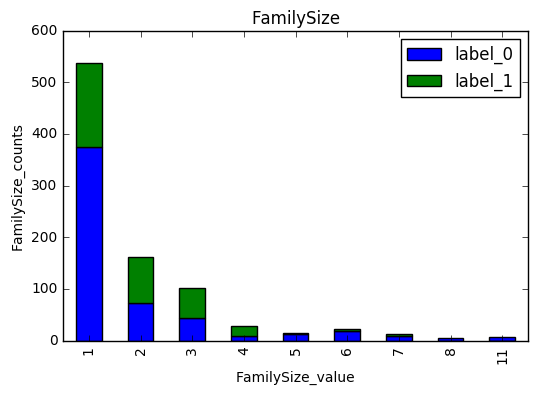

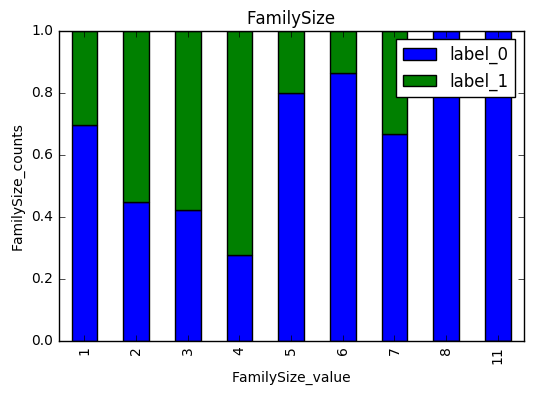

In [7]:

full_data=[data_train,data_test]
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
def validate_disper_feature(data_train,column_name,label):
    print (data_train[[column_name, label]].groupby([column_name], as_index=False).mean())
    value_set = data_train[label].value_counts().keys()
    value_counts = {}
    for label_value in value_set:
        value_counts.update(
            {'label_' + str(label_value): data_train[data_train[label] == label_value][column_name].value_counts()})

    df = pd.DataFrame(value_counts)
    df.plot(kind='bar', stacked=True)
    plt.title(column_name)
    plt.xlabel(column_name + "_value")
    plt.ylabel(column_name + "_counts")
    plt.show()

    #每列调整为100%，
    for index_name in df.index:
        df.loc[index_name].fillna(0,inplace=True)
        df.loc[index_name]=df.loc[index_name]*1.0/df.loc[index_name].sum()
    df.plot(kind='bar', stacked=True)
    plt.title(column_name)
    plt.xlabel(column_name + "_value")
    plt.ylabel(column_name + "_counts")
    plt.show()

validate_disper_feature(data_train,'FamilySize','Survived')

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


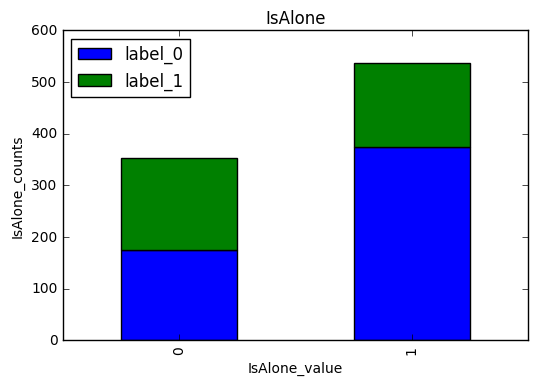

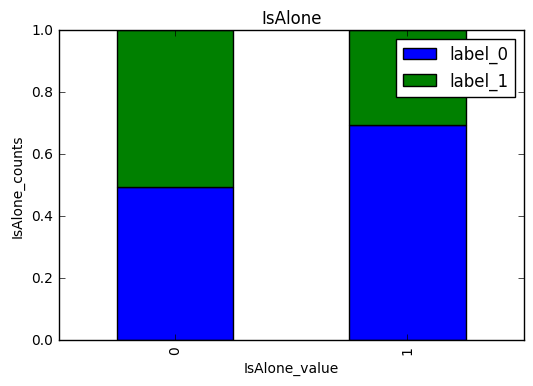

In [8]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
validate_disper_feature(data_train,'IsAlone','Survived')

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


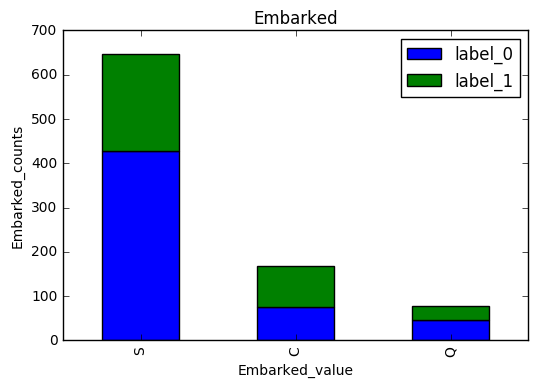

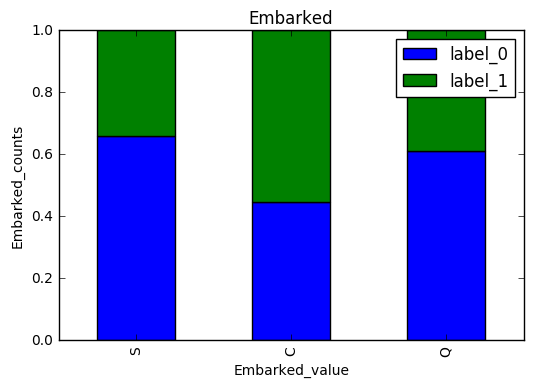

In [9]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
validate_disper_feature(data_train,'Embarked','Survived')

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


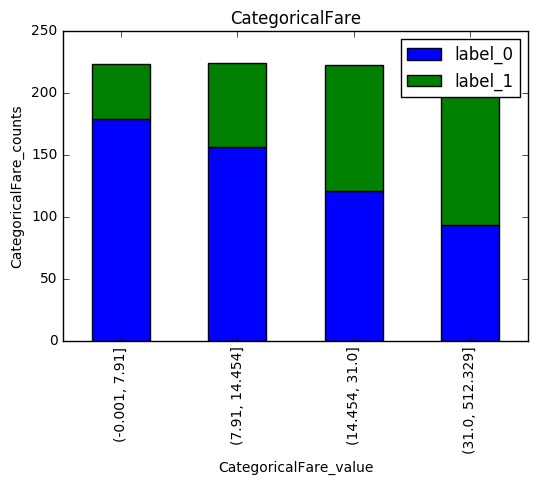

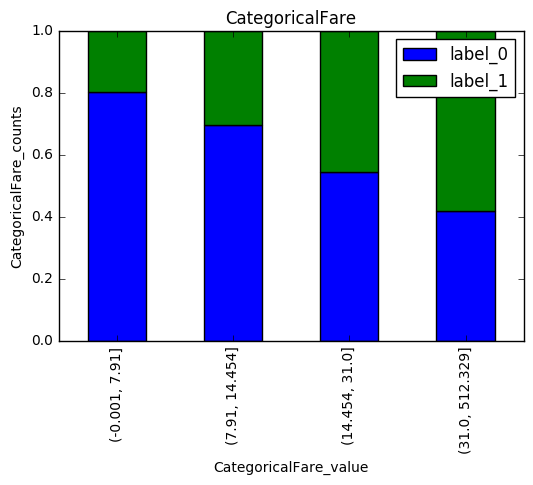

In [10]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(data_train['Fare'].median())
data_train['CategoricalFare'] = pd.qcut(data_train['Fare'], 4)
validate_disper_feature(data_train,'CategoricalFare','Survived')

c:\python27\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


  CategoricalAge  Survived
0  (-0.08, 16.0]  0.508929
1   (16.0, 32.0]  0.366890
2   (32.0, 48.0]  0.357143
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


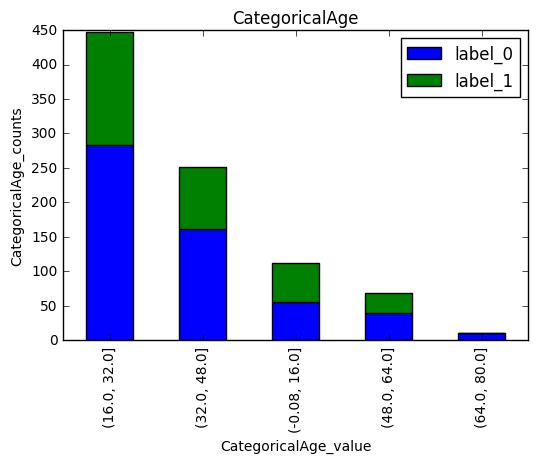

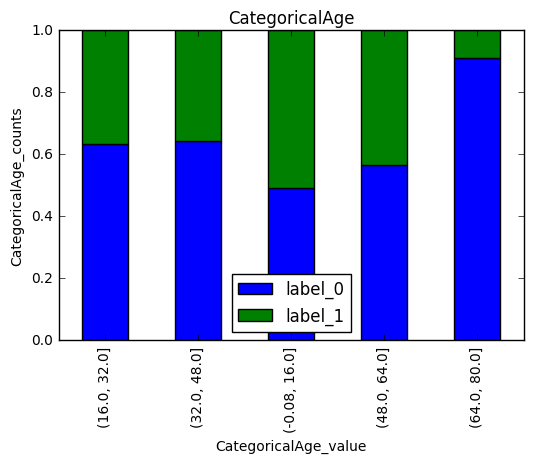

In [11]:
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
data_train['CategoricalAge'] = pd.cut(data_train['Age'], 5)

validate_disper_feature(data_train,'CategoricalAge','Survived')

In [12]:
import re as re
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(data_train['Title'], data_train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [13]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (data_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [14]:

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
data_train = data_train.drop(drop_elements, axis = 1)
data_train = data_train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
data_train_org=data_train.copy()
data_test_org=data_test.copy()
data_test  = data_test.drop(drop_elements, axis = 1)

print (data_train.head(10))

train_value = data_train.values
test_value  = data_test.values
%matplotlib inline 


   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    1     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


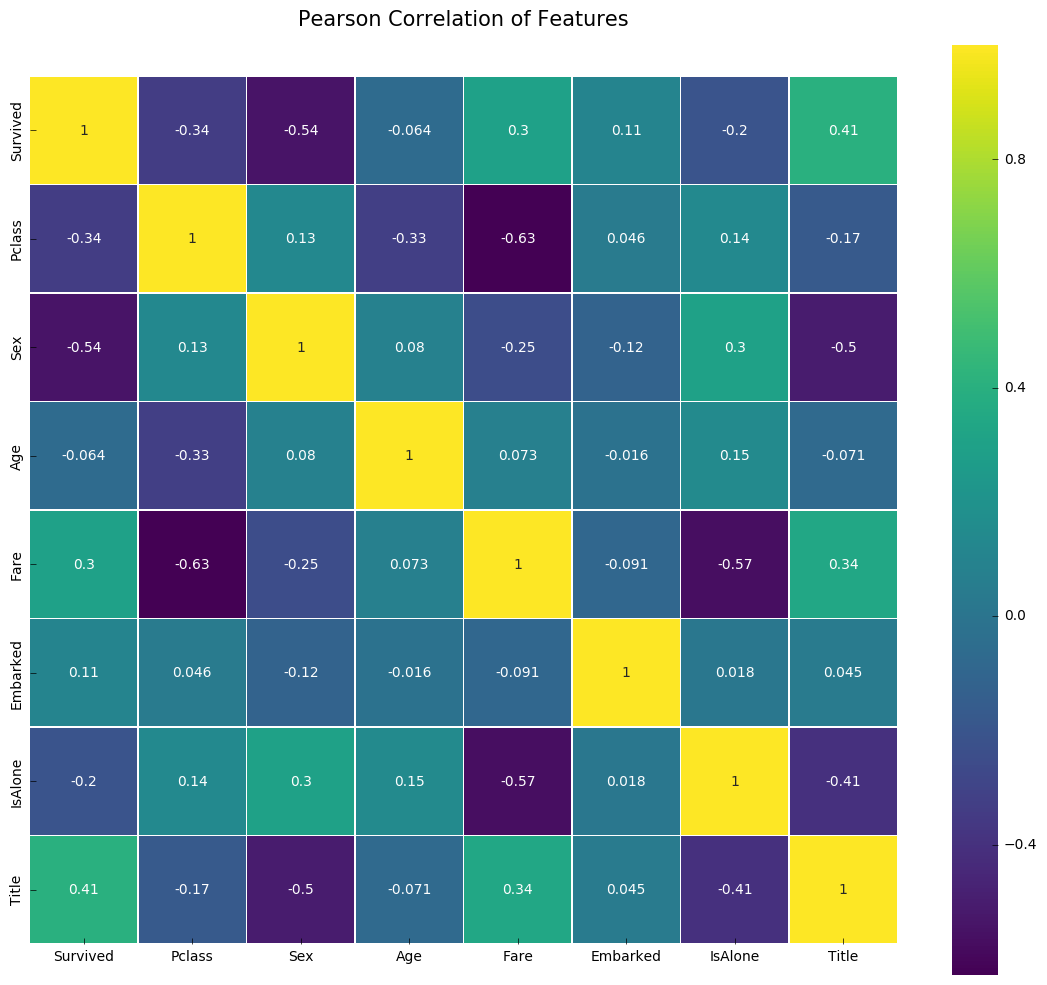

In [16]:
%matplotlib inline
import seaborn as sns
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)


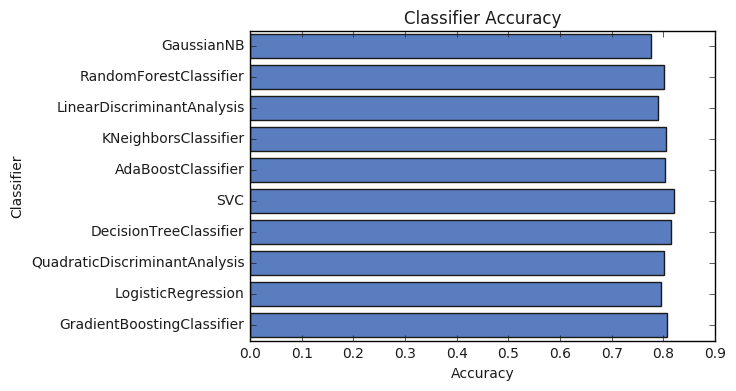

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%matplotlib inline

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_value[0::, 1::]
y = train_value[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [19]:
candidate_classifier = GradientBoostingClassifier()
candidate_classifier.fit(train_value[0::, 1::], train_value[0::, 0])
result = candidate_classifier.predict(test_value)
data_test_org['result']=result
data_test_org[['PassengerId','result']].to_csv("d:\\TDDOWNLOAD\\ML\\titanic\\officialData\\result.csv",index=False)

In [ ]:
g = sns.pairplot(data_train[[u'Survived', u'Pclass', u'Sex', u'Age',  u'Fare', u'Embarked',
       u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [ ]:


#属性的缺失值处理，Embarked
data_train['Embarked'] = data_train['Embarked'].fillna('S')
data_test['Embarked'] = data_test['Embarked'].fillna('S')

data_train['Fare'] = data_train['Fare'].fillna(data_train['Fare'].median())
data_test['Fare'] = data_test['Fare'].fillna(data_train['Fare'].median())
data_train['CategoricalFare'] = pd.qcut(data_train['Fare'], 4)

print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())


#特殊数据归一化
scaler = preprocessing.StandardScaler()
data_train['Age'].fillna(data_train['Age'].median(),inplace=True)
data_test['Age'].fillna(data_train['Age'].median(),inplace=True)
age_scale_param = scaler.fit(data_train['Age'].values.reshape(-1,1))
data_train['Age'] = scaler.fit_transform(data_train['Age'].values.reshape(-1,1), age_scale_param)
data_test['Age'] = scaler.fit_transform(data_test['Age'].values.reshape(-1,1), age_scale_param)

data_train['Fare'].fillna(data_train['Fare'].median(),inplace=True)
data_test['Fare'].fillna(data_train['Fare'].median(),inplace=True)
fare_scale_param = scaler.fit(data_train['Fare'].values.reshape(-1,1))
data_train['Fare'] = scaler.fit_transform(data_train['Fare'].values.reshape(-1,1), fare_scale_param)
data_test['Fare'] = scaler.fit_transform(data_test['Fare'].values.reshape(-1,1), fare_scale_param)

columns=['Age',"Fare"]
show_destr(data_train,columns)

In [ ]:
columns=['Embarked','Sex','Pclass','Cabin']
data_train,data_test=columns_dummies(data_train,data_test,columns)
data_train=data_train.drop(['Ticket','Name'],axis=1)
data_test=data_test.drop(['Ticket','Name'],axis=1)
print data_train.head()

In [ ]:
# 用正则取出我们要的属性值
train_df = data_train.filter(regex='Survived|Cabin_*|Age|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
test_df = data_test.filter(regex='Cabin_*|Age|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
print train_df.head()
train_np = train_df.as_matrix()
test_np=test_df.as_matrix()
print 'train_df.columns()',train_df.columns
print 'test_df.columns()',test_df.columns

In [ ]:
from sklearn import linear_model

# y即Survival结果
y = train_np[:, 0]
# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# clf.fit(X, y)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X,y)
predictions = bagging_clf.predict(test_df)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("d:\\TDDOWNLOAD\\ML\\titanic\\officialData\\logistic_regression_predictions.csv", index=False)


In [ ]:
# print list(train_df.columns)
# print pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

In [ ]:
#判断是否过拟合
data_x=X
data_y=y
train_sizes,train_loss,test_loss=learning_curve(clf,data_x,data_y,train_sizes=np.linspace(0.05,1,20))

train_loss_mean=np.mean(train_loss,axis=1)
test_loss_mean=np.mean(test_loss,axis=1)

plt.plot(train_sizes,train_loss_mean,'o-',color='r',label='train_loss_mean')
plt.plot(train_sizes,test_loss_mean,'o-',color='g',label='test_loss_mean')
plt.xlabel('train_sizes')
plt.ylabel('loss')
plt.show()

从上图可以看出，并没有过拟合现象